#### In this Notebook we are able to download several days of CMEMS data and merge it into a single NetCDF file. Then we will import that NetCDF and convert it to an xarray. We can then apply the 3 algorithms (Canny, BOA and CCA), obtaining a Frontal Probability map for each algorithm and save the results in a folder called CMEMS_seasonal_images.

#### Due to the lower resolution of the SST images of the CMEMS compared to the MUR data, the generated frontal probabilities maps from CMEMS will be of poorer quality and more difficult to interpret


### VERY IMPORTANT:
### To download CMEMS data the user must have an account in the Copernicus Marine Service

## Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
import cv2
import matplotlib
from matplotlib.colors import ListedColormap
from scipy.ndimage import gaussian_filter
import time
import sys
import wget
from math import floor
from pydap.client import open_url
from tqdm import tqdm
import sys
import netCDF4 as nc
import glob
from datetime import date, timedelta
import datetime
import motuclient

import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = 12, 8

/home/luisfigueiredo/.local/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


### Import functions to apply the BOA and CCA, which are defined in other notebooks

In [4]:
#import functions to aplly the BOA
from ipynb.fs.full.BOA_functions import boa

In [44]:
#import functions to aplly the CCA
from ipynb.fs.full.CCA_functions_xarray import getFrontInWindow
from ipynb.fs.full.CCA_functions_xarray import CCA_SIED

## ---------------- FUNCTIONS TO DOWNLOAD CMEMS_REANALYSIS DATA ----------------------

In [1]:
# this class will be used to parse the motuclient options from a dictionary:
class MotuOptions:
    def __init__(self, attrs: dict):
        super(MotuOptions, self).__setattr__("attrs", attrs)

    def __setattr__(self, k, v):
        self.attrs[k] = v

    def __getattr__(self, k):
        try:
            return self.attrs[k]
        except KeyError:
            return None

In [2]:
#This objective of this function is:   
# post-process the script_template (displayed clicking on VIEW SCRIPT) to create a dictionary; returns this dictionary to feed the download of the data request
def motu_option_parser(script_template, usr, pwd, output_filename, output_directory):
    dictionary = dict([e.strip().partition(" ")[::2] for e in script_template.split('--')])
    dictionary['variable'] = [value for (var, value) in [e.strip().partition(" ")[::2] for e in script_template.split('--')] if var == 'variable']  
    for k, v in list(dictionary.items()):
        if v == '<OUTPUT_DIRECTORY>':
            dictionary[k] = output_directory
        if v == '<OUTPUT_FILENAME>':
            dictionary[k] = output_filename
        if v == '<USERNAME>':
            dictionary[k] = usr
        if v == '<PASSWORD>':
            dictionary[k] = pwd
        if k in ['longitude-min', 'longitude-max', 'latitude-min', 'latitude-max']:
            dictionary[k] = float(v)
        if k in ['date-min', 'date-max']:
            dictionary[k] = v[1:-1]
        dictionary[k.replace('-','_')] = dictionary.pop(k)
    dictionary.pop('python')
    dictionary['auth_mode'] = 'cas'
    return dictionary

In [45]:
def download_CMEMS2(start_date, end_date, USERNAME, PASSWORD, netcdf_name, OUTPUT_DIRECTORY='../data/CMEMS_seasonal_data'):
    
    """
    Function to download CMEMS data for a certain day. start_date and end_date are strings is in format %Y-%m-%d.
    The NetCDF will be stored in the CMEMS_seasonal_data folder.
    The CMEMS has SST data for each hour of the day but we will choose daily data at 12:30
    
    VERY IMPORTANT: --> to download CMEMS data is required a create an account in the Copernicus Marine Service
    So its necessary to have a USERNAME and a PASSWORD
    """
    
    base_path = os.getcwd()
    
    exist_path = os.path.exists(os.path.join(base_path, '../data/CMEMS_seasonal_data'))   #check if folder MUR_seasonal_data exists in data folder
    if not exist_path:                                                                  #if it don't exist:
        os.makedirs(os.path.join(base_path, '../data/CMEMS_seasonal_data'))               #create the folder
    
    start_date = start_date + ' 12:30:00'
    end_date = end_date + ' 12:30:00'

    sdate = datetime.datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
    edate = datetime.datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S')

    delta = edate-sdate
    dates_list = []
    for i in range(delta.days +1):
        day = sdate + timedelta(days=i)
        day = day.strftime('%Y-%m-%d')
        dates_list.append(day)

    for i in range(len(dates_list)):

        data = ''
        #Get the data in the format we want: data always at 12:30
        data = dates_list[i] + ' 12:30:00'

        OUTPUT_FILENAME = 'CMEMS_' + dates_list[i] +'.nc'

        script_template = f'python -m motuclient \
            --motu https://nrt.cmems-du.eu/motu-web/Motu \
            --service-id IBI_ANALYSISFORECAST_PHY_005_001-TDS \
            --product-id cmems_mod_ibi_phy_anfc_0.027deg-2D_PT1H-m \
            --longitude-min -19 --longitude-max -5 \
            --latitude-min 35 --latitude-max 45 \
            --date-min "{data}" --date-max "{data}" \
            --variable thetao \
            --out-dir <OUTPUT_DIRECTORY> \
            --out-name <OUTPUT_FILENAME> \
            --user <USERNAME> --pwd <PASSWORD>'


        data_request_options_dict_automated = motu_option_parser(script_template, USERNAME, PASSWORD, OUTPUT_FILENAME, OUTPUT_DIRECTORY)
        #print(data_request_options_dict_automated)

        motuclient.motu_api.execute_request(MotuOptions(data_request_options_dict_automated))
    
    
    ds = xr.open_mfdataset('../data/CMEMS_seasonal_data/CMEMS*.nc',combine = 'nested', concat_dim="time")
    
    ds.to_netcdf('../data/CMEMS_seasonal_data/SST_CMEMS_' + netcdf_name + '.nc')
    
    #Now that the several netCDF files are merged into a single NetCDF, we should delete the individual files
    for filename in glob.glob("../data/CMEMS_seasonal_data/CMEMS*.nc"):
        os.remove(filename) 

In [ ]:
USERNAME = "*****************"
PASSWORD = "*****************"

In [13]:
download_CMEMS2(start_date='2022-12-23', end_date='2022-12-26', USERNAME=USERNAME, PASSWORD=PASSWORD, netcdf_name='christmas', OUTPUT_DIRECTORY='../data/CMEMS_seasonal_data')

## Import Data
We are going to import the data from the NetCDF and convert it to an xarray

In [63]:
def get_data(data):
    
    """
    Function to get our netCDF file that is stored in the data directory inside the MUR_seasonal_data folder and convert it to a dataframe.
    The data parameter is the string name of the netCDF file we want to import
    """
    
    base_path = os.getcwd()
    data_folder = os.path.join(base_path, "../data/CMEMS_seasonal_data")  
    
    nc_path = os.path.join(data_folder, data)
    data_xarray = xr.load_dataset(nc_path)
    
 
    # Rename the coordinates
    data_xarray = data_xarray.rename({'latitude': 'lat', 'longitude': 'lon', 'time': 'time'})

    # Rename the variable
    data_xarray = data_xarray.rename_vars({'thetao': 'analysed_sst'})
    
    
    return data_xarray

In [64]:
xarray_test = get_data('SST_CMEMS_christmas.nc')
xarray_test

<xarray.Dataset>
Dimensions:       (lat: 361, lon: 505, time: 4)
Coordinates:
  * lat           (lat) float32 35.0 35.03 35.06 35.08 ... 44.94 44.97 45.0
  * time          (time) datetime64[ns] 2022-12-23T12:30:00 ... 2022-12-26T12...
  * lon           (lon) float32 -19.0 -18.97 -18.94 ... -5.056 -5.028 -5.0
Data variables:
    analysed_sst  (time, lat, lon) float32 19.4 19.39 19.38 ... 14.13 14.11
Attributes: (12/24)
    Conventions:                        CF-1.0
    title:                              Ocean surface hourly mean fields for ...
    source:                             NEMO3.6
    domain_name:                        IBI36
    FROM_ORIGINAL_FILE__field_type:     mean
    field_date:                         20230308
    ...                                 ...
    institution:                        Nologin (Spain)
    references:                         http://marine.copernicus.eu/
    contact:                            mailto: servicedesk.cmems@mercator-oc...
    _CoordSysBuilder:                   ucar.nc2.dataset.conv.CF1Convention
    comment:                            
    history:                            Data extracted from dataset http://lo...

In [48]:
# CREATE A FOLDER TO STORE THE IMAGE RESULTS OF THE FRONTAL PROBABILITY MAPS
base_path = os.getcwd()

exist_path = os.path.exists(os.path.join(base_path, '../data/CMEMS_seasonal_images'))   
if not exist_path:                                                                  
    os.makedirs(os.path.join(base_path, '../data/CMEMS_seasonal_images'))     

## ------------------------------------ Canny Algorithm Functions -----------------------------------------

In [65]:
def canny_front_calc(data_xarray, Tmin, Tmax, sigma=5, apertureSize=5):  
    
    """
    Function that receives a dataframe with SST data relative to a certain day and returns the front matrix 
    obtained due to the aplication of the Canny algorithm.
    For each image a Gaussian filter (with a certain sigma value) might be applied (depending on the data)
    Tmin and Tmax are the limits of the threshold and apertureSize is the size of the Sobel operator (default=3X3)
    """
    
    #Convert the df to a numpy array with the SST values for the coordinate pair (longitude and latitude)
#    sst = data_xarray.pivot_table(index='lon', columns='lat', values='analysed_sst').T.values 
    Temp = data_xarray['analysed_sst'].values[0]
    
    #Convert the temperature values to the uint8 format with values between 0-255
    Temp_day = ((Temp - np.nanmin(Temp)) * (1/(np.nanmax(Temp) - np.nanmin(Temp)) * 255)).astype('uint8')

    Temp_day = np.flipud(Temp_day)   #flipud -> Reverse the order of elements along axis 0 (up/down).
    
    #if its MUR data we have to apply gaussian filter with certain sigma value (~5)
    Temp_day = gaussian_filter(Temp_day, sigma=sigma)
    
    #apply the canny algorithm from OpenCV
    canny = cv2.Canny(Temp_day, Tmin, Tmax, L2gradient=False, apertureSize=apertureSize)
    
    return canny  #return the matrix (if a pixel was considered a front than its value is 255; otherwise is 0)

In [66]:
def frontal_prob_canny(data_xarray, Tmin, Tmax, sigma=5, apertureSize=5):
    """
    This function receives several front matrices and for that period calculates the frontal_probability. 
    Then it creates a masked_array so that the continental zone is well defined.
    This masked_array is applied to the frontal probabilities matrix, which is returned
    """
    
    lat_dims = data_xarray.dims['lat']
    lon_dims = data_xarray.dims['lon']
    
    time_dims = data_xarray.dims['time']
    
    fp = np.zeros((lat_dims,lon_dims))   #if its MUR data, fp shape must be (1001, 1401)
    
    
    for date in data_xarray['time'].values:
        x = data_xarray.sel(time=slice(date, date))
        fp = fp + canny_front_calc(x, Tmin=Tmin, Tmax=Tmax, sigma=sigma, apertureSize=apertureSize)
        
    
    fp = fp/(time_dims*255)*100   # to get the fp in percentage 
    
    return fp 

In [67]:
fp_canny = frontal_prob_canny(xarray_test, Tmin=120, Tmax=220, sigma=5, apertureSize=5)

In [68]:
def canny_frontal_prob_visualization(data_xarray, fp_canny, vmin=None, vmax=None):
    
    """
    Function to visualize the map of frontal probability.
    vmin and vmax define the data range that the colormap covers -> it helps for visualization purposes.
    """
    base_path = os.getcwd()
    
    #first we apply the frontal_prob function to a certain period of data
    fp = fp_canny.copy()
    
    #Create a mask for our continental zone 
    sst = data_xarray['analysed_sst'].values[0]
    mask = np.isnan(np.flipud(sst))    #Boolean array is True where original array (Temp) had Null values
    mask255 =np.where(mask,(np.ones(mask.shape))*255,0).astype("uint8")   #array which pixels = 255 when mask=True
    #Make a dilation to ensure the pixels that belong to the shore are not consideredd fronts
    kernel = np.ones((3,3), np.uint8)
    mask_dilated = cv2.dilate(mask255, kernel)
    
    fp = np.ma.masked_where(mask_dilated==255, fp)
    
    lat_max = xarray_test['lat'].values.max()
    lat_min = xarray_test['lat'].values.min()
    lon_max = xarray_test['lon'].values.max()
    lon_min = xarray_test['lon'].values.min()
    
    
    #Visualization purposes: continenal area in gray, and pixels with value=0 in white   
    viridis = matplotlib.cm.get_cmap('viridis', 100)
    newcolor = viridis(np.linspace(0,1,100))
    white = np.array([1, 1, 1, 1])
    newcolor[0, :] = white
    newcmp = ListedColormap(newcolor)
    newcmp.set_bad(color='gray')

    plt.figure()
    plt.imshow(fp, cmap=newcmp, vmin=vmin, vmax=vmax, extent=[lon_min, lon_max, lat_min, lat_max]) 
    plt.colorbar(orientation='horizontal', fraction=0.025, pad=0.08, aspect=50, label='Frontal Probability (%)')
    plt.title("CANNY Frontal Probabilities (CMEMS)", fontsize=20)
    plt.savefig(os.path.join(base_path, '../data/CMEMS_seasonal_images/CANNY_frontal_prob.jpg'))

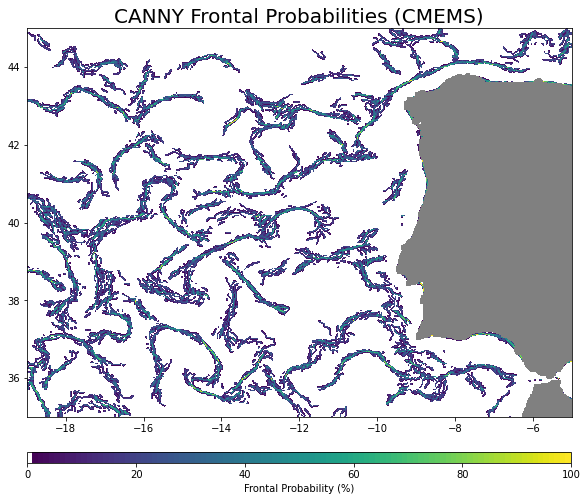

In [69]:
canny_frontal_prob_visualization(xarray_test, fp_canny=fp_canny, vmin=None, vmax=None)

## --------------------- Belkin O'Reilly Algorithm (BOA) Functions --------------------------------

In [70]:
def BOA_aplication(data_xarray, threshold=0.3):  
    
    """
    Function to, for a given xarray with a longitude, latitude and SST columns, 
    identifies fronts through the application of BOA algorithm.
    We also need to define a threshold value to later get the frontal probabilities matrix
    (if the pixel value is greater than the threshold, then it is considered a front, otherwise its not). 
    """
    
    lat = data_xarray['lat'].values
    lon = data_xarray['lon'].values
    ingrid = data_xarray['analysed_sst'].values[0]
    
    front = boa(lon=lon, lat=lat, ingrid=ingrid, nodata = np.nan, direction = False)
    front = np.flip(front, axis=0)
    front = np.array([[front[j][i] for j in range(len(front))] for i in range(len(front[0])-1,-1,-1)])
    
    front = np.where(front>=threshold, 1, front)    
    front = np.where(front<threshold, 0, front)
    
    return front

In [71]:
def frontal_prob_boa(data_xarray, threshold=0.3):
    
    """
    Function applies BOA to several images and returns the matrix of frontal probabilities for certain period.
    The matrices resulting from the application of BOA are summed and divided by the number of days
    to obtain a front probabilities matrix.
    """
    
    lat_dims = data_xarray.dims['lat']
    lon_dims = data_xarray.dims['lon']
    time_dims = data_xarray.dims['time']

    
    fp = np.zeros((lat_dims,lon_dims))   #if its MUR data, fp shape must be (1001, 1401) 
      
        
    for date in data_xarray['time'].values:
        x = data_xarray.sel(time=slice(date, date))
        fp = fp + BOA_aplication(x, threshold=threshold)

    
    fp = fp/(time_dims)*100      #for the calculation of the FP we divide by the number of periods (days) and multiply by 100 (%)
    
    return fp

In [72]:
def boa_frontal_prob_visualization(data_xarray, fp_boa, vmin=None, vmax=None):
    
    """
    Function to visualize the map of frontal probability.
    vmin and vmax define the data range that the colormap covers -> it helps for visualization purposes.
    """
    base_path = os.getcwd()
    
    #first we apply the frontal_prob function to a certain period of data
    fp = fp_boa.copy()
    
    #Create a mask for our continental zone 
    sst = data_xarray['analysed_sst'].values[0]    #using the first array of the xarray
    mask = np.isnan(np.flipud(sst))    #Boolean array is True where original array (Temp) had Null values
    mask255 =np.where(mask,(np.ones(mask.shape))*255,0).astype("uint8")   #array which pixels = 255 when mask=True
    #Make a dilation to ensure the pixels that belong to the shore are not consideredd fronts
    kernel = np.ones((3,3), np.uint8)
    mask_dilated = cv2.dilate(mask255, kernel)
    
    fp = np.ma.masked_where(mask_dilated==255, fp)
    
    lat_max = data_xarray['lat'].values.max()
    lat_min = data_xarray['lat'].values.min()
    lon_max = data_xarray['lon'].values.max()
    lon_min = data_xarray['lon'].values.min()
    
    
    #Visualization purposes: continenal area in gray, and pixels with value=0 in white   
    viridis = matplotlib.cm.get_cmap('viridis', 100)
    newcolor = viridis(np.linspace(0,1,100))
    white = np.array([1, 1, 1, 1])
    newcolor[0, :] = white
    newcmp = ListedColormap(newcolor)
    newcmp.set_bad(color='gray')

    plt.figure()
    plt.imshow(fp, cmap=newcmp, vmin=vmin, vmax=vmax, extent=[lon_min, lon_max, lat_min, lat_max]) 
    plt.colorbar(orientation='horizontal', fraction=0.025, pad=0.08, aspect=50, label='Frontal Probability (%)')
    plt.title("BOA Frontal Probabilities (CMEMS)", fontsize=20)
    plt.savefig(os.path.join(base_path, '../data/CMEMS_seasonal_images/BOA_frontal_prob.jpg'))

In [73]:
boa_f = frontal_prob_boa(xarray_test, threshold=0.3)

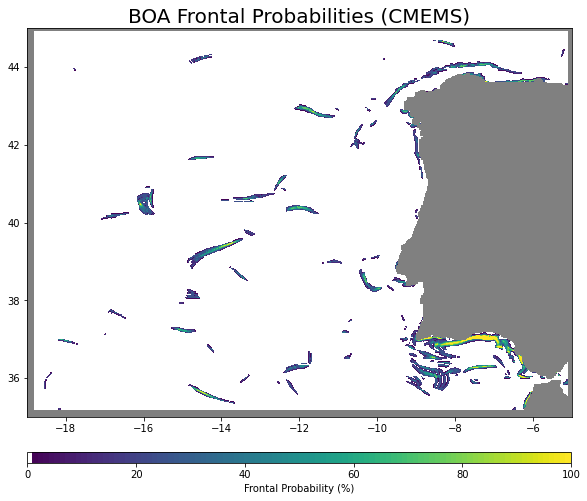

In [74]:
boa_frontal_prob_visualization(xarray_test, boa_f, vmin=None, vmax=None)

## ---------------------- Cayula-Cornillon Algorithm Functions ----------------------------------

In [75]:
def front_calc(data_xarray): 
    
    """
    Function that calculates the fronts matrix. Given an image (SST data respective to one day) it applies the
    Cayula-Cornillon Algorithm for Single Image Edge Detection (CCA-SIED) to discover the fronts.
    It returns the matrix with the fronts: if pixel = 1 it was considered a front, otherwise, pixel = 0
    It basically converts the (x,y) coordinate points to indexes of the frontal probability matrix. These indexes are considered fronts
    """
    
    
    
    lat_dims = data_xarray.dims['lat']
    lon_dims = data_xarray.dims['lon']
    
    lat_max = data_xarray['lat'].values.max()
    lat_min = data_xarray['lat'].values.min()
    lon_max = data_xarray['lon'].values.max()
    lon_min = data_xarray['lon'].values.min()
    
    div_rows = (lat_max-lat_min)/lat_dims
    div_cols = (lon_max-lon_min)/lon_dims
    
    fp = np.zeros((lat_dims,lon_dims))       #initialize a matrix of zeros
    

    #2 empty arrays that will store the x and y values of the lines that are suposed to be drawn
    x = np.array([])
    y = np.array([])
        
    xdata_final, ydata_final = CCA_SIED(data_xarray)       
    x = np.append(x, xdata_final)
    y = np.append(y, ydata_final)
        
    cols_x = np.array([])
    for value in x:                     #convert values in array x to the respective index in a (1001, 1401) matrix
        aux_x = (-lon_min+value)/div_cols                  #these numbers are relative to the MUR data
        cols_x = np.append(cols_x, aux_x)
    
    rows_y = np.array([])
    for value in y:                     #convert values in array y to the respective index in a (1001, 1401) matrix
        aux_y = (lat_max-value)/div_rows               #these numbers are relative to the MUR data
        rows_y = np.append(rows_y, aux_y)
     
    cols_x = np.round(cols_x)
    rows_y = np.round(rows_y)
            
    for i in range(len(cols_x)):   #it could also be len(rows_y)
        fp[int(rows_y[i]), int(cols_x[i])] = fp[int(rows_y[i]), int(cols_x[i])] + 1
        

            
    fp[fp != 0] = 1
    
    return fp  

In [76]:
def frontal_prob_cca(data_xarray):
    
    """
    Function that allows the visualization of the Frontal Probabilities for the Cayula-Cornillon Algorithm (CCA).
    This function also applies a mask to the frontal probabilities array in order for the continental zone to be 
    well defined. The function plots the frontal probabilities
    """
    
    lat_dims = data_xarray.dims['lat']
    lon_dims = data_xarray.dims['lon']
    
    time_dims = data_xarray.dims['time']
    
    front_prob = np.zeros((lat_dims, lon_dims))    #for the resolution of the MUR data
    
    for date in data_xarray['time'].values:
        x = data_xarray.sel(time=slice(date, date))
        front = front_calc(x)
        front_prob += front
        
    
    front_prob = front_prob/(time_dims)*100   # to get the fp in percentage

    return front_prob
    

In [77]:
def cca_frontal_prob_visualization(data_xarray, fp_cca, vmin=None, vmax=None):
    
    """
    Function to visualize the map of frontal probability.
    vmin and vmax define the data range that the colormap covers -> it helps for visualization purposes.
    """
    base_path = os.getcwd()
    
    #first we apply the frontal_prob function to a certain period of data
    fp = fp_cca.copy()
    
    #Create a mask for our continental zone 
    sst = data_xarray['analysed_sst'].values[0]    #using the first array of the xarray
    mask = np.isnan(np.flipud(sst))    #Boolean array is True where original array (Temp) had Null values
    mask255 =np.where(mask,(np.ones(mask.shape))*255,0).astype("uint8")   #array which pixels = 255 when mask=True
    #Make a dilation to ensure the pixels that belong to the shore are not consideredd fronts
    kernel = np.ones((3,3), np.uint8)
    mask_dilated = cv2.dilate(mask255, kernel)
    
    fp = np.ma.masked_where(mask_dilated==255, fp)
    
    lat_max = data_xarray['lat'].values.max()
    lat_min = data_xarray['lat'].values.min()
    lon_max = data_xarray['lon'].values.max()
    lon_min = data_xarray['lon'].values.min()
    
    
    #Visualization purposes: continenal area in gray, and pixels with value=0 in white   
    viridis = matplotlib.cm.get_cmap('viridis', 100)
    newcolor = viridis(np.linspace(0,1,100))
    white = np.array([1, 1, 1, 1])
    newcolor[0, :] = white
    newcmp = ListedColormap(newcolor)
    newcmp.set_bad(color='gray')

    plt.figure()
    plt.imshow(fp, cmap=newcmp, vmin=vmin, vmax=vmax, extent=[lon_min, lon_max, lat_min, lat_max]) 
    plt.colorbar(orientation='horizontal', fraction=0.025, pad=0.08, aspect=50, label='Frontal Probability (%)')
    plt.title("CCA Frontal Probabilities (CMEMS)", fontsize=20)
    plt.savefig(os.path.join(base_path, '../data/CMEMS_seasonal_images/CCA_frontal_prob.jpg'))

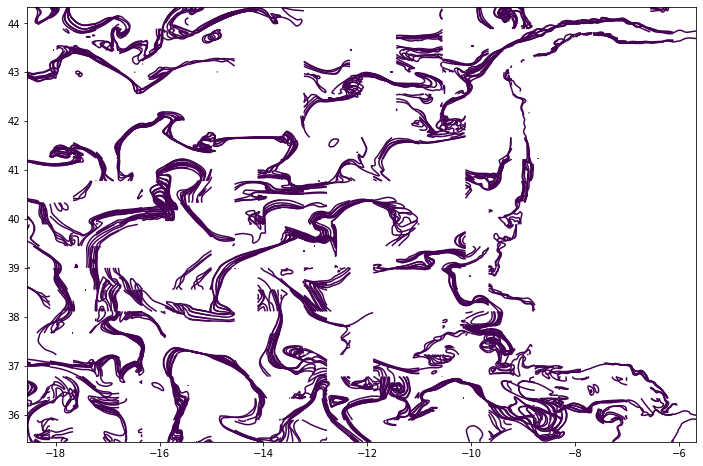

In [78]:
cca_f = frontal_prob_cca(xarray_test)

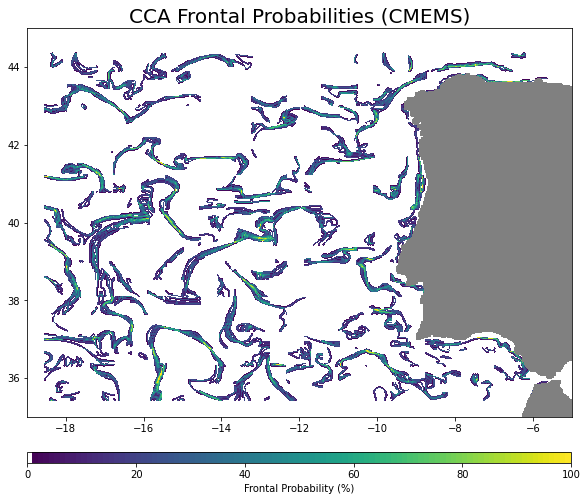

In [79]:
cca_frontal_prob_visualization(xarray_test, cca_f, vmin=None, vmax=None)